# 基于Amazon Nova的大规模视频内容分类方法
1. 需求背景
2. 需求分析
3. 方案选型
4. 系统架构和实现
5. 踩坑总结与心得

## 1. 需求背景
客户是做新闻资讯app，有较多的站外内容，入库前需要对图文/推特/视频（抖音、titok、YouTube）等内容分析、生成Tags标签和实现一、二、三级分类。
客户目前除了视频、还有大量的图文信息，图文信息的分类目前主要用的是GPT4o来实现的，另外还有使用GPT4o 来做内容语言识别（输入标题和文章内容，输出语音标签）。

分类如下格式：
```json
[{
    "catetory1": "Economy & Business",
    "catetory2": "Companies & Enterprises",
    "catetory3": ["Corporate News & Events", "Startups & Investments"],
    "weight": {
        "Economy & Business": 75,
        "Companies & Enterprises": 70,
        "Corporate News & Events": 65,
        "Startups & Investments": 68
    }
}]
```

标签如下格式：
```json
[
    {
        "tag": "OKX",
        "scores": 100
    },
    {
        "tag": "DOGE",
        "scores": 90
    },
    {
        "tag": "圣诞红包",
        "scores": 80
    },
    {
        "tag": "家人",
        "scores": 70
    },
     ...
    }
]
```

### [视频sample](https://s3-video.x.me/dy/video/2025-01-23/01/35740d6cf7dd4c63b0945377ef16f71d.mp4)

## 2. 需求分析
### 客户短视频为主
- 系统主要处理短视频内容，需要高效、准确的分类方案
- 平均视频长度小于1分钟

### 成本因素考量
- 视频处理的API调用成本需要严格控制
- 每个视频的处理时间和资源消耗需要最小化
- 平衡准确率和处理成本的最优解决方案

### 处理规模
- 存量视频约100万条
- 每周新增视频约10万条
- 需要高效的批量处理能力和可扩展的系统架构

### 技术选型考量
- 利用Amazon Bedrock的Nova多模态模型，支持原生视频输入
- 无需额外的视频预处理步骤，可以直接处理视频内容


## 3. 方案选型

### 模型对比

| 特性 | Nova Lite | Nova Pro |
| --- | --- | --- |
| 一次分类准确率 | ~50% | ~90% |
| 处理速度 | 更快 | 较慢 |
| Token成本 | 更低 | 较高 |


### 分类方法对比

| 特性 | 一步分类法 | 两步分类法 |
| --- | --- | --- |
| 处理流程 | 单次模型调用 | 两次模型调用 |
| 准确性 | 较低 | 较高 |
| 处理时间 | 更短 | 更长 |

### 最终选择
- **使用Nova Pro模型进行一次分类**
- 每个视频截取前30秒进行分析, 减少整体成本，方案简单。
- 整体成本可控，准确率高达90%以上，经过向量化搜索匹配后，应该可以达到客户需求。


## 4. 系统架构和实现

### 总体架构
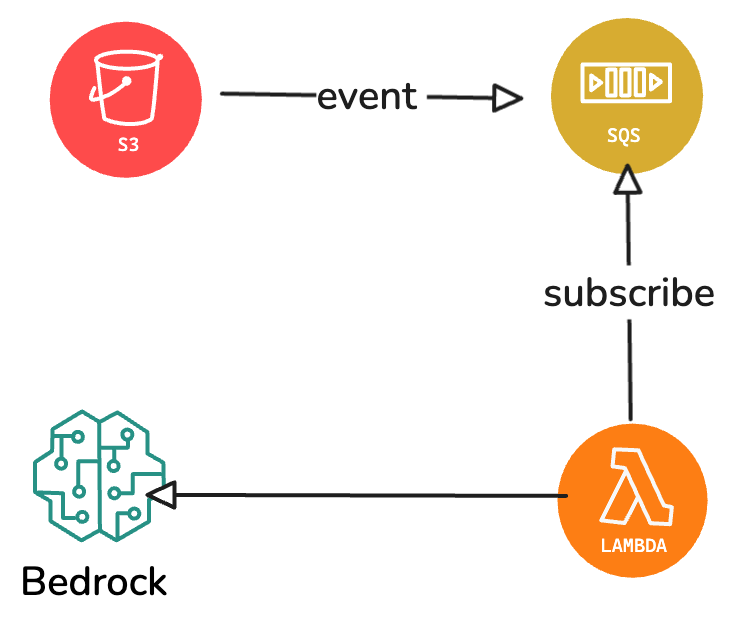
- S3存储视频内容，新增视频触发事件使用SQS
- AWS Lambda 订阅 SQS 触发后，调用bedrock 处理视频分类


### 核心模块
- **视频处理模块**: 处理视频提取和预处理
- **分类模块**: 调用Bedrock API进行视频分类
- **json格式校准**: 处理json格式，格式异常时使用Amazon lite 二次校准
- **结果校准模块**: 对比分类，使用Titan Embeddings 查找最接近分类



### 处理流程
```mermaid
flowchart TD
    Start[开始处理] --> CheckDuration[检查视频时长]
    CheckDuration --> |>30秒| TrimVideo[截取前30秒]
    CheckDuration --> |≤30秒| LoadPrompt[加载提示词]
    TrimVideo --> LoadPrompt
    
    LoadPrompt --> OneStep{分类方法?}
    
    OneStep --> |一步分类| CallBedrock1[调用Bedrock一次]
    OneStep --> |两步分类| FirstCall[第一步:内容理解]
    
    FirstCall --> SecondCall[第二步:分类]
    SecondCall --> ParseResult2[解析结果]
    
    CallBedrock1 --> ParseResult1[解析结果]
    ParseResult1 --> ValidateJSON{JSON格式有效?}
    ParseResult2 --> ValidateJSON
    
    ValidateJSON --> |否| RepairJSON[使用Nova Lite修复]
    ValidateJSON --> |是| ValidateCategory{分类存在?}
    RepairJSON --> ValidateCategory
    
    ValidateCategory --> |否| FindSimilar[使用Titan Embed查找相似分类]
    ValidateCategory --> |是| CalibrateResults[校准分类结果]
    FindSimilar --> CalibrateResults
    
    CalibrateResults --> SaveResults[保存结果]
```

### 系统状态管理

```mermaid
stateDiagram-v2
    [*] --> 待分类
    待分类 --> 待格式修正: JSON格式正确
    待分类 --> 失败: 分类错误
    
    待格式修正 --> 待分类修正: 修复JSON格式
    待格式修正 --> 失败: 修复失败
    
    待分类修正 --> 分类完成: 分类正确
    待分类修正 --> 失败: 分类错误
    
    分类完成 --> [*]
    失败 --> 人工干预
    人工干预 --> 待分类: 手动重启
    人工干预 --> [*]: 放弃处理
```

## 5. 踩坑总结

### 配额问题
- **问题**: 新账号默认quota只有1/10，无法满足大规模处理需求
- **解决**: 提前申请提高配额，建立配额监控系统

### 资源限制和BUG
- **问题**: Bedrock接口频繁返回503、424异常，影响客户体验
- **问题**: 请求失败可能导致客户重复分类，造成额外成本
- **解决**: 修复接口报错导致的重复推理，保存每一步大模型的输出状态

### 使用状态机完成任务
- **实现**: 
- 每个任务只处理其中一个状态
- 每次模型调用后立即保存结果，避免重复调用

### Bedrock调用
- **TopP参数调整**: 设置为0.9平衡多样性和一致性，设置太低导致部分分类不输出
- **Temperature设置**: 低温度(0.0)确保输出一致性
- **处理超时**: 设置适当的超时时间，避免长时间等待自动断开。

### Prompt工程
- **问题**: 大的input内容会降低模型遵循指令的准确性
- **问题**: JSON输出格式经常缺失样本字段，需要修复
- **解决**: ，使用结构化的XML输出格式提高稳定性
- **尝试其他**: 使用两步分类法时，第一步仅提取内容理解，第二步专注分类，效果差别不大，但是token 消耗增加0.5倍

### embededding增强
- **问题**: 单个级别的分类字段长度较短，在向量化后去查询相似分类，效果不够好。
- **解决**: 一级分类： append增加二级分类，一起embedding； 二级分类： append增加一级分类+三级分类，一起embedding，依次类推。
